In [71]:
%matplotlib notebook

from matplotlib.pyplot import *;
from numpy import *;
from numpy.linalg import *;
from scipy.linalg import *;
from control.matlab import *;
import matplotlib.pyplot as plt
from scipy.io import *
import scipy

In [72]:
# 1) Zadatak
# a) Crtamo residuale

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)

mat = loadmat('CDplayer.mat')
A = scipy.sparse.csr_matrix.todense(mat['A']);
B = matrix(mat['B'])[:, 1];
C = matrix(mat['C'])[0, :];

sys_G = ss(A, B, C, matrix(zeros((C.shape[0], B.shape[1]))));

x = range(10, 41)
u = [];

def nrm2(sys_H):
    #P = gram(sys_H, 'c');
    P = lyap(sys_H.A, sys_H.B * sys_H.B.T)
    C = sys_H.C;
    return sqrt(trace(C * P * C.H));
    
for r in x:
    sys_Gt = balred(sys_G, r)
    u.append(nrm2(sys_G - sys_Gt));


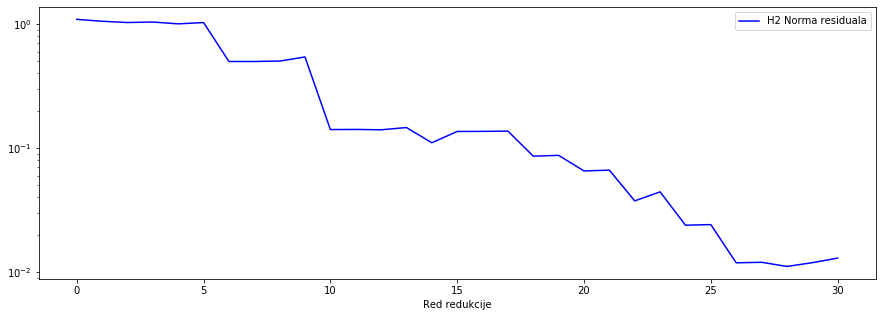

[1.0939843077566236, 1.055676055026418, 1.0316393096012648, 1.0408371014349111, 1.0062447246922195, 1.030832240506267, 0.5000250280520386, 0.5001413331044142, 0.5038113165801085, 0.5438429899560135, 0.1411401665030023, 0.1414720670989381, 0.1405105518119653, 0.1465344670438164, 0.11046639701915544, 0.13619358280387606, 0.1364552999327735, 0.1371232519661579, 0.08612427652123696, 0.08735525355916353, 0.06539235958487291, 0.0664193369599584, 0.03750908618417653, 0.04433691131767797, 0.023870168141019298, 0.02413603878963657, 0.011861778072005266, 0.01198298805978878, 0.011089471048745997, 0.011888428197034864, 0.012939741682569379]


In [73]:
f = figure();
#plot(x, u, 'b-', label = 'H2 Norma residuala');
semilogy(u, 'b-', label = 'H2 Norma residuala');

legend();
xlabel('Red redukcije')
show();
print(u)

In [134]:
# IRKA
def gramsc(A):
    n, m = A.shape
    Q = matrix(zeros((n, m)), dtype = complex128);
    for i in range(m):
        Q[:, i] = A[:, i];
        for j in range(i):
            Q[:, i] -= (Q[:, j].H * Q[:, i])[0, 0] * Q[:, j];
        
        Q[:, i] /= norm(Q[:, i], 2);
        
    for i in range(m):
        for j in range(i):
            Q[:, i] -= (Q[:, j].H * Q[:, i])[0, 0] * Q[:, j];
        
        Q[:, i] /= norm(Q[:, i], 2);
    
    return matrix(Q, dtype = complex128);

def IRKA(sys_G, red):
    A = matrix(sys_G.A, dtype = 'complex');
    B = matrix(sys_G.B, dtype = 'complex');
    C = matrix(sys_G.C, dtype = 'complex');
    
    n = A.shape[0];
    m = B.shape[1];
    p = C.shape[0];
    
    E = matrix(eye(n), complex128);
    
    sigma = 1e-1 + (1e3 - 1e-1) * random.rand(red);
    #r = matrix(1e-1 + (1e3 - 1e-1) * random.rand(m, red));
    #e = matrix(1e-1 + (1e3 - 1e-1) * random.rand(p, red));
    r = matrix(ones((m, red)));
    e = matrix(ones((p, red)));
    
    V = matrix(zeros((n, red)), dtype = complex128);
    W = matrix(zeros((n, red)), dtype = complex128);
    prevEig = zeros(n);
    lim = 20;
    for k in range(lim):
        for i in range(red):
            V[:, i] = solve(sigma[i] * E - A, B * r[:, i]);
            W[:, i] = solve((sigma[i] * E - A).H, C.H * e[:, i]);

        #V, _ = qr(V, mode = 'economic');
        #W, _= qr(W, mode = 'economic');
        #V = matrix(V);
        #W = matrix(W);
        V = gramsc(V);
        W = gramsc(W);
        
        E_P = W.H * E * V;
        A_P = W.H * A * V;
        B_P = W.H * B;
        C_P = C * V;
        
        print(cond(E_P), norm(W.H*W-eye(red)), norm(V.H*V-eye(red)));
        Eig, X = eig(A_P, E_P);
        X = matrix(X, dtype = complex128);
        
        #r = C_P * X;
        #e = matrix(solve(E_P * X, B_P)).H;
        
        sigma = -Eig;
        sys_H = ss(solve(E_P, A_P), solve(E_P, B_P), C_P, sys_G.D);
        #greska = nrm2(sys_H - sys_G) / nrm2(sys_G);
        #print("{} Relativna greška: {}".format(k, greska))
        prevEig = Eig;
        
    f = figure();
        
    bode(sys_H);
    bode(sys_G)
    
    greska = nrm2(sys_H - sys_G) / nrm2(sys_G);
    print("Relativna greška: {}".format(greska))
        
    f = figure();
    plot(prevEig.real, prevEig.imag, 'ro');
    plot(Eig.real, Eig.imag, 'b*')
    

570412567.2186989 3.036024185888398e-13 2.1297115973428026e-13
1445105991.1984596 1.2428641809277595e-15 1.5807800026975708e-15
193238661.01191205 1.5686539310034816e-15 1.4563571122150277e-15
1145300877.698156 1.108578483483385e-15 1.2524272586383869e-15
31931223.528410878 1.5494711899645668e-15 1.7938549291780673e-15
245819588.6844417 1.2047909319807688e-15 1.0999221411695389e-15
61330856.24133727 1.2333761783107574e-15 1.4248800991220106e-15
157626203.30928612 1.2345524024942554e-15 1.449474630688659e-15
79814571.02003966 1.4235441773795874e-15 1.422724305934718e-15
134233221.72892743 1.3422925602912051e-15 1.4307038978913403e-15
84306699.41538423 1.2276995102569161e-15 1.5023999121457053e-15
126054369.70541678 1.4192621636636053e-15 1.3823915840651948e-15
86308624.68890323 1.6832864985088618e-15 1.4079386689309615e-15
122311607.27661227 1.2561089675058459e-15 1.8278116140663797e-15
87562883.9161207 1.2535358343262982e-15 1.2954111466639438e-15
120293051.58606578 1.2764208295933856e

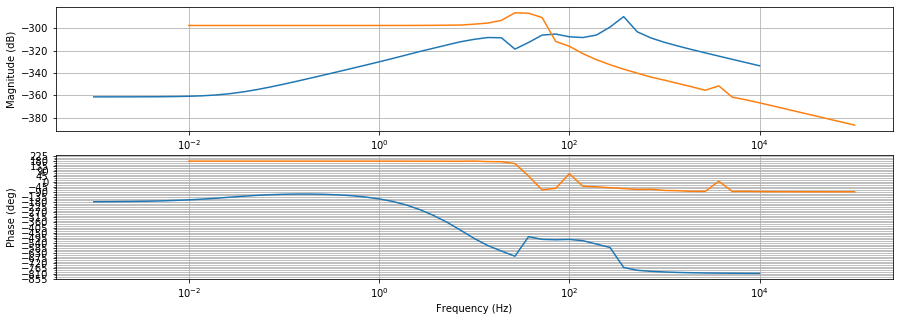

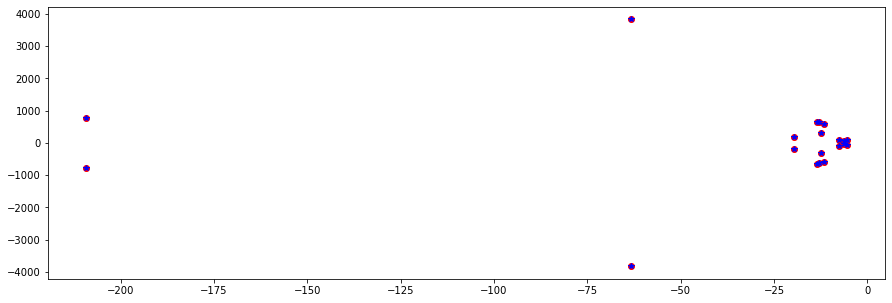

In [135]:
IRKA(sys_G, 20)

In [119]:
h = matrix(rand.randn(2)) + j * matrix(rand.randn(2)) 
v = matrix(rand.randn(2)) + j ;

NameError: name 'rand' is not defined